In [10]:
import numpy as np 
import pandas as pd 
from utils import * 
from src.files import BLASTJsonFile, MASTFile
import subprocess
from tqdm import tqdm
import os
from Bio import Entrez 
import xml
import glob
import re
from Bio.Seq import Seq
import matplotlib.pyplot as plt 
from src.data import * 

Entrez.email = 'prichter@berkeley.edu'
data_dir = '../data/data-2'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# First get all proteins annotated as VirC1 in the NCBI database. 
# esearch -db protein -query "VirC1" | efetch -format acc
virc1_ids = pd.read_csv('../data/data-2/virc1_ids.txt', header=None, names=['id']).values.ravel()

In [12]:
def get_nuccore_links(protein_id):
    handle = Entrez.elink(dbfrom='protein', db='nuccore', id=protein_id, retmax=1, retmode='xml')
    tree = xml.etree.ElementTree.fromstring(handle.read())
    links = [link.find('Id').text for link in tree.findall('**/Link')]
    return links

def get_assembly_link(nuccore_id):
    handle = Entrez.elink(dbfrom='nuccore', db='assembly', id=nuccore_id, retmax=1, retmode='xml')
    tree = xml.etree.ElementTree.fromstring(handle.read())
    links = [link.find('Id').text for link in tree.findall('**/Link')]
    if len(links) == 0:
        # print(f'get_assembly_link: No assembly link for nuccore ID {nuccore_id}')
        return None
    return links[-1]

def get_ncbi_data(virc1_ids, path:str='../data/data-2/virc1.csv'):

    dfs = list()
    if os.path.exists(path):
        dfs.append(pd.read_csv(path, index_col=0))
        virc1_ids = [id_ for id_ in virc1_ids if (id_ not in dfs[0].index)]

    df = list()
    # virc1_ids = [','.join(chunk) for chunk in np.array_split(virc1_ids, 100)]
    for id_ in tqdm(virc1_ids, desc='get_ncbi_data'):

        try:
            links = get_nuccore_links(id_)
            for link in links:
                handle = Entrez.esummary(db='nuccore', id=link, retmode='xml')
                tree = xml.etree.ElementTree.fromstring(handle.read())

                row = dict()
                row['protein_id'] = id_
                row['nuccore_id'] = tree.find('.//Item[@Name="Caption"]').text
                row['title'] = tree.find('.//Item[@Name="Title"]').text
                row['assembly_link'] = get_assembly_link(row['nuccore_id'])
                row['nuccore_link'] = link

                if row['assembly_link'] is not None:
                    handle = Entrez.esummary(db='assembly', id=row['assembly_link'], retmode='xml')
                    tree = xml.etree.ElementTree.fromstring(handle.read())
                    assembly_id = tree.find('**/AssemblyAccession')
                    row['assembly_id'] = assembly_id.text if (assembly_id is not None) else 'none'
                    row['organism'] = tree.find('**/Organism').text

                df.append(row) 
                
        except Exception as err:
            print(f'get_ncbi_data: An error occurred, {err}.')
            break
        
    if len(df) == 0:
        print('get_ncbi_data: No data added.')
    else:
        dfs.append(pd.DataFrame(df).set_index('protein_id'))

    df = pd.concat(dfs)
    df.to_csv(path)
    print(f'get_ncbi_data: Nuccore accessions written to  {path}.')

# get_ncbi_data(virc1_ids)


In [13]:
def get_assembly(assembly_ids:list, assembly_dir:str=None):
    assembly_ids = ','.join(assembly_ids)
    cmd = f'datasets download genome accession {assembly_ids} --include genome'
    subprocess.run(cmd, shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(f'unzip -o ncbi_dataset.zip -d {assembly_dir}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL) # Unzip and overwrite existing files. 

get_genome_id = lambda file_name : re.search(r'GC[AF]_\d+\.\d+', file_name).group(0)

def get_sequences(ncbi_df:pd.DataFrame, nuccore_dir:str='../data/data-2/ncbi/nuccore', assembly_dir:str='../data/data-2/ncbi/assembly'):

    assembly_ids = ncbi_df.assembly_id.dropna().unique()
    nuccore_ids = ncbi_df[ncbi_df.assembly_id.isnull()].nuccore_id.unique()

    for id_ in tqdm(nuccore_ids, desc='get_sequences: Downloading nucleotide sequences.'):
        path = os.path.join(nuccore_dir, f'{id_}.1.fn')
        if os.path.exists(path):
            continue 
        handle = Entrez.efetch(db='nuccore', id=id_, rettype='fasta', retmode='text')
        with open(path, 'w') as f:
            f.write(handle.read())
    
    downloaded_assembly_ids = [os.path.basename(path).replace('.fn', '') for path in glob.glob(os.path.join(assembly_dir, '*'))]
    assembly_ids = [id_ for id_ in assembly_ids if (id_ not in downloaded_assembly_ids)] # Don't re-download assemblies.
    assembly_ids = np.array_split(assembly_ids, 50) # Download assembly IDs in chunks. 
    assembly_ids = [ids for ids in assembly_ids if len(ids) > 0]

    for ids in tqdm(assembly_ids, desc='get_sequences: Downloading assemblies.'):
        get_assembly(ids, assembly_dir=assembly_dir)

    # Unpack the downloaded NCBI assemblies.
    for path in glob.glob(f'{assembly_dir}/**/*.fna', recursive=True):
        genome_id = get_genome_id(path)
        subprocess.run(f'mv {path} ../data/data-2/ncbi/assembly/{genome_id}.fn', shell=True, check=True)

# get_sequences(df)
    

In [14]:
for path in tqdm(glob.glob('../data/data-2/ncbi/**/*.fn'), 'Running HMM...'):
    source_id = os.path.basename(path).replace('.fn', '')
    output_path = f'../data/data-2/hmmer/{source_id}.tsv'
    if not os.path.exists(output_path):
        try:
            # Default HMMer E-value threshold is 10. 
            cmd = f'nhmmer -E 10 --tblout {output_path} ../data/data-1/hmms/library.hmm {path}'
            subprocess.run(cmd, shell=True, check=True, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        except:
            print(f'HMMer could not be run for sequence {source_id}, the file is probably empty.')


Running HMM...: 100%|██████████| 1778/1778 [00:00<00:00, 51998.53it/s]

HMMer could not be run for sequence CAIIUG000000000.1, the file is probably empty.
HMMer could not be run for sequence FCPG000000000.1, the file is probably empty.
HMMer could not be run for sequence CAIITH000000000.1, the file is probably empty.


In [15]:
hmmer_df = load_hmmer_files(hmmer_dir=os.path.join(data_dir, 'hmmer'), max_e_value=0.05)
overdrive_df = build_overdrive_dataset(overwrite=False, fasta_dir='../data/data-2/ncbi/', hmmer_df=hmmer_df, length=200, data_dir=data_dir)
overdrive_df = overdrive_df[~overdrive_df.seq.isnull()].copy() # There are 3 null sequences for some reason. 
                            
virc1_df = pd.read_csv('../data/data-2/virc1.csv')

for field in ['organism', 'title']:
    map_ = virc1_df.drop_duplicates('nuccore_id').set_index('nuccore_id')[field].to_dict()
    map_ = {id_ + '.1':value for id_, value in map_.items()}
    map_.update(virc1_df.drop_duplicates('assembly_id').set_index('assembly_id')[field].to_dict())
    overdrive_df[field] = overdrive_df.source_id.map(map_)
    overdrive_df[field] = np.where(overdrive_df[field].isnull(), overdrive_df.source_id.map(map_), overdrive_df[field])

overdrive_df['ri_plasmid'] = overdrive_df.title.str.contains('Ri', case=True)
print('\nNum. Ri plasmids in the dataset:', overdrive_df.ri_plasmid.sum())
overdrive_df = overdrive_df[~overdrive_df.ri_plasmid].copy()
overdrive_df.to_csv('../data/data-2/overdrive.csv')

# Ran meme on the collected putative sequences with no orientation constraints, based on the results of the original
# overdrive paper which suggested that orientation doesn't matter. 

load_hmmer: Num. hits for query T-DNA_left_border: 1061
load_hmmer: Num. hits for query T-DNA_right_border: 1066
load_hmmer: Num. hits for query overdrive: 117
build_overdrive_dataset: Found 730 right borders.

Num. Ri plasmids in the dataset: 0


In [16]:
source_ids = overdrive_df.source_id.unique() # Grab all source IDs in the dataset. 
source_ids = [source_id.replace('GCF', 'GCA') for source_id in source_ids if (source_id.startswith('GCF'))] + list(source_ids)

# Load the assembly IDs associated with the Weisberg et. al. 2020 paper, deposited under BioProject PRJNA607555.
with open('../data/data-1/weisberg_2020_assemblies.txt', 'r') as f:
    weisberg_assembly_ids = f.readlines()
    print('Num. assemblies associated with Weisberg 2020 paper:', len(weisberg_assembly_ids))
    weisberg_assembly_ids = [line.split()[0] for line in weisberg_assembly_ids if (line.startswith('GCA'))]
    weisberg_assembly_ids = [id_.replace('GCA', 'GCF') for id_ in weisberg_assembly_ids] + list(weisberg_assembly_ids)

# names = ['assembly_id', 'level', 'wgs', 'chrs', 'biosample', 'strain', 'taxonomy', 'none']
# weisberg_assembly_metadata_df = pd.read_csv('../data/data-1/weisberg_2020_assemblies.txt', comment='#', sep='\t', index_col=0, header=None, names=names)
# weisberg_assembly_metadata_df = weisberg_assembly_metadata_df.drop(columns=['none'])
# weisberg_assembly_metadata_df['strain_id'] = weisberg_assembly_metadata_df.strain.str.replace('/', '_').replace(' ', '_')

print('Removing potential overdrives which overlap with the Weisberg dataset:', overdrive_df.source_id.isin(weisberg_assembly_ids).sum())

overdrive_df = overdrive_df[~overdrive_df.source_id.isin(weisberg_assembly_ids)].copy()
overdrive_df = pd.concat([overdrive_df, pd.read_csv('../data/data-1/overdrive.csv', index_col=0)])
print('Num. potential overdrive sequences in the final dataset:', len(overdrive_df))

# Write regions adjacent to the right border to a FASTA file.
FASTAFile(df=overdrive_df.set_index('id')).write('../data/data-2/overdrive.fn')

Num. assemblies associated with Weisberg 2020 paper: 210
Removing potential overdrives which overlap with the Weisberg dataset: 551
Num. potential overdrive sequences in the final dataset: 2071


In [17]:
cols = ['query', 'target', 'evalue', 'pident', 'bits', 'qseq', 'tseq', 'alnlen', 'qstart', 'qend', 'tstart', 'tend']
align_df = pd.read_csv('../data/data-2/overdrive_align.tsv', sep='\t', header=None, names=cols)
align_df = align_df[align_df.bits > 50].copy()
align_df['start_offset'] = np.abs(align_df.qstart - align_df.tstart)
align_df['alignment_id'] = [' - '.join(sorted([row.target, row.query])) for row in align_df.itertuples()]
align_df = align_df[align_df['query'] != align_df['target']].copy() # Drop self-alignments.
align_df = align_df.sort_values('bits').drop_duplicates('alignment_id') # Drop duplicate alignments.

min_group_size = 10
graph = get_alignment_graph(align_df, overdrive_df.index.values)
alignment_groups = list(nx.connected_components(graph))
print('Num. alignment groups:', len(alignment_groups))
print(f'Num. alignment groups > {min_group_size} members:', len([group for group in alignment_groups if (len(group) > min_group_size)]))
alignment_group_map = {id_:i for i, group in enumerate(alignment_groups) for id_ in group}
overdrive_df['group'] = overdrive_df.index.map(alignment_group_map)


Num. alignment groups: 1723
Num. alignment groups > 10 members: 21


In [18]:
import re 
re.search('OD_NZ_JBHMAA010000029.1_40712-4091', 'OD_NZ_JBHMAA010000029.1_40712-40912')
'OD_NZ_JBHMAA010000029.1_40712-40912' in overdrive_df.index

False

In [19]:


# ATTTGTGTGT 1a_10 best possible match. 
# TGTTTGTTTGTTTGT 1a_15 best possible match. 
# TTGTCTGTTCGTTCATTTGT 1a_20 best possible match. 

# ACACACAAAT
motif_lengths = [10, 20, 25]
motif_dfs = dict()
for motif_length in motif_lengths:
    mast_file = MASTFile(f'../data/data-2/meme/overdrive_mast_width_{motif_length}.txt', motif_length=motif_length)
    mast_file.correct_ids(overdrive_df.index.values)
    motif_dfs[f'motif_1a_{motif_length}'] = mast_file.to_df()
    overdrive_df[f'motif_1a_{motif_length}'] = overdrive_df.index.isin(motif_dfs[f'motif_1a_{motif_length}']['id'])

# overdrive_df['has_motif_1a_10'] = overdrive_df.index.isin(motif_1a_10_df['id'])
# overdrive_df['has_motif_1a_15'] = overdrive_df.index.isin(motif_1a_15_df['id'])
# overdrive_df['has_motif_1a_20'] = overdrive_df.index.isin(motif_1a_20_df['id'])
# overdrive_df['has_motif_1a_25'] = overdrive_df.index.isin(motif_1a_25_df['id'])

MASTFile.correct_ids: 464 IDs to correct.


TypeError: cannot use a string pattern on a bytes-like object

Num. sequences: 679


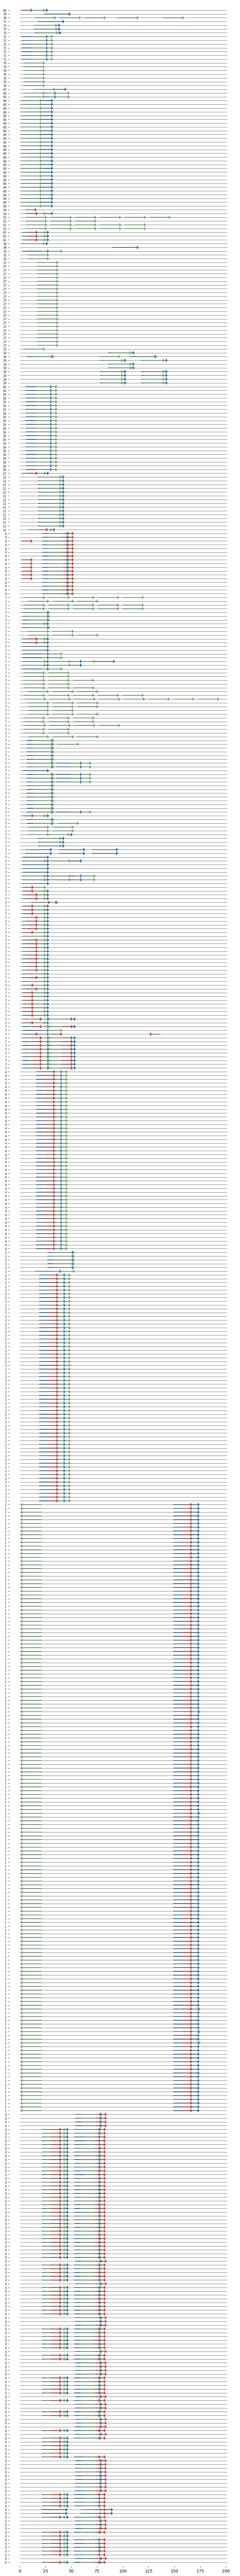

In [ ]:

palette = {'motif_1a_10':'indianred', 'motif_1a_25':'steelblue', 'motif_1a_20':'darkseagreen'}

figure_df = pd.concat([df.assign(motif=motif) for motif, df in motif_dfs.items()]) # .iloc[:20]
figure_df['group'] = figure_df['id'].map(alignment_group_map)
figure_df = figure_df.sort_values('group')

# figure_df['plasmid_type'] = figure_df['id'].map(overdrive_df.plasmid_type)
# figure_df = figure_df[~figure_df.plasmid_type.isnull()]
# figure_df = figure_df[figure_df.plasmid_type.str.contains('Type I')]


# figure_df['n_hits'] = figure_df['id'].map(figure_df.groupby('id').motif.nunique())
# figure_df = figure_df.sort_values('n_hits', ascending=False)
# figure_df = figure_df[figure_df.n_hits == 4].copy()
# figure_df = figure_df[figure_df.strand == '+'].copy()

n = figure_df['id'].nunique()
print('Num. sequences:', n)

fig, ax = plt.subplots(figsize=(10, n//6))

y = 0
x_min, x_max = 0, 201
y_labels = list()

for id_, df in figure_df.groupby('id', sort=False):
    ax.hlines(y, xmax=x_max, xmin=x_min, color='black', lw=0.5)
    df = df.sort_values('length', ascending=False)
    for motif, df_ in df.groupby('motif', sort=False):
        # ax.hlines(y, xmin=df_.start, xmax=df_.stop, color=palette[motif], lw=1.5)
        df_ = df_.sort_values('length', ascending=False)
        for row in df_.itertuples():
            dx = row.length if (row.strand == '+') else -row.length 
            x = row.start if (row.strand == '+') else row.stop 
            ax.arrow(x, y, dx, 0, length_includes_head=True, color=palette[motif], lw=1.5, head_width=0.8, alpha=1)
    y_labels.append(int(row.group))
    y += 1

ax.set_ylim(ymax=y + 1, ymin=-1)
ax.set_yticks(np.arange(y), labels=y_labels, fontsize='x-small')
for _, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()


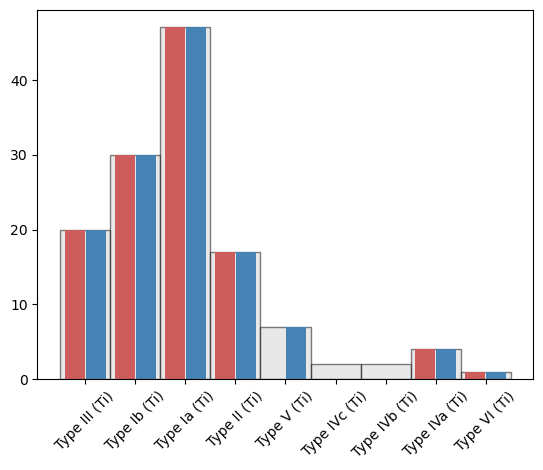

In [ ]:
metadata_df = load_weisberg_2020_metadata()
metadata_df['source_id'] = [f'{row.strain_id}_{row.plasmid_class.lower()}' for row in metadata_df.itertuples()]
metadata_df = metadata_df[metadata_df.plasmid_class == 'Ti'].copy()

index = overdrive_df.index
figure_df = overdrive_df.merge(metadata_df, left_on='source_id', right_on='source_id', how='left')
figure_df.index = index 

palette = {'motif_1a_10':'indianred', 'motif_1a_25':'steelblue'}
offsets = {'motif_1a_10':-0.21, 'motif_1a_25':0.21}

figure_df = figure_df[~figure_df.plasmid_type.isnull()].copy()
plasmid_types = figure_df.plasmid_type.unique()

fig, ax = plt.subplots()
totals = [(figure_df.drop_duplicates('source_id').plasmid_type == plasmid_type).sum() for plasmid_type in plasmid_types]
    
positions = np.arange(len(plasmid_types))
ax.bar(positions, totals, color='lightgray', alpha=0.5, width=1, edgecolor='black')
for motif in palette.keys():
    df = figure_df[figure_df[f'{motif}']].drop_duplicates('source_id')
    # print(motif, len(df))
    heights = [(df.plasmid_type == plasmid_type).sum() for plasmid_type in plasmid_types]
    # heights = np.array(heights) / np.array(totals)
    ax.bar(positions + offsets[motif], heights, color=palette[motif], width=0.4)

ax.set_xticks(positions, labels=plasmid_types, rotation=45)
plt.show()


# df = df.sort_values('has_motif', ascending=False).drop_duplicates('source_id')

In [ ]:
# TODO: Look at the relative numbers of right borders and left borders in each fragment to try to determine how many of the 
# right borders may be duplicated, and therefore have a disrupted upstream region. 

hmmer_df['has_t_dna'] = has_t_dna(hmmer_df)

# TODO: Try to map the alignment groups to annotated plasmid types. 

# Right and left borders are direct repeats, meaning they are on the same strand. They are homologous, but not identical; however
# they can have 80-90% similarity. The right border sequence is more highly-conserved, which suggests that the HMM may be more prone
# to labeling a right border as a left border than vice versa (although I can't be sure that the opposite does not occur; indeed, based on the 
# average number of left and right borders per sequence, it seems as though there are slightly more annotated right borders). 

# Left borders are generally less conserved, as the right border is where the VirD nick site is. Termination is not as essential; apparently
# if termination does not occur, then part of the plasmid backbone may end up being transformed. 

print('Num. unique contigs:', hmmer_df.target_name.nunique())
print('Num. contigs with both left and right borders:', hmmer_df.drop_duplicates('target_name').has_t_dna.sum())
# print('Average number of left borders per sequence:', hmmer_df[hmmer_df.query_name == 'T-DNA_left_border'].value_counts('target_name').mean())
# print('Average number of right borders per sequence:', hmmer_df[hmmer_df.query_name == 'T-DNA_right_border'].value_counts('target_name').mean())

def has_conflict(row, hmmer_df:pd.DataFrame=hmmer_df):
    hmmer_df = hmmer_df[hmmer_df.target_name == row.target_name].copy() # Get the hits within the same sequence. 
    start, stop = min(row.target_from, row.target_to), max(row.target_from, row.target_to)
    hmmer_df['overlap'] = ~((hmmer_df.start > stop) | (hmmer_df.stop < start) | (hmmer_df.index == row.name))
    return hmmer_df.overlap.sum() > 0

def has_left_border(right_border_row, hmmer_df:pd.DataFrame=hmmer_df):
    mask = (hmmer_df.target_name == row.target_name) & (hmmer_df.strand == row.strand) & (hmmer_df.query_name == 'T-DNA_left_border')
    if mask.sum() == 0:
        return False
    hmmer_df = hmmer_df[mask]
    start, stop = right_border_row.start, right_border_row.stop
    n_left_borders = (((hmmer_df.stop < start) & (hmmer_df.strand == '+')) | ((hmmer_df.start > stop) & (hmmer_df.strand == '-'))).sum()
    return n_left_borders > 0

right_border_df = hmmer_df[hmmer_df.query_name == 'T-DNA_right_border'].copy()
right_border_df['has_conflict'] =  right_border_df.apply(has_conflict, axis=1)
right_border_df['has_left_border'] =  right_border_df.apply(has_left_border, axis=1)

print('Num. right borders:', len(right_border_df))
print('Num. right borders with conflict:', right_border_df.has_conflict.sum())
print('Num. right borders with a corresponding left border:', right_border_df.has_left_border.sum())


Num. unique contigs: 875
Num. contigs with both left and right borders: 537
Num. right borders: 1066
Num. right borders with conflict: 469
Num. right borders with a corresponding left border: 450


In [ ]:
# For a right border to be valid, I am requiring that it either (1) has no conflict with a left border,
# or (2) has an annotated left border to the left on the same strand. 

# How many non-overlapping annotated borders per sequence?


# hmmer_df[hmmer_df.query_name != 'overdrive'].value_counts('target_name')

In [ ]:
border_df

,start,stop,contig_id,e_value,strand,annotation,overlapping_e_value
0,170934,170958,AB016260.1,0.000010,+,T-DNA_left_border,0.00012
1,197026,197048,AB016260.1,0.000027,+,T-DNA_right_border,NaN
2,14992,15017,AF242881.1,0.000015,+,T-DNA_left_border,0.00014
3,1,24,AF242881.1,0.000078,+,T-DNA_left_border,0.01000
4,22855,22877,AF242881.1,0.000120,+,T-DNA_right_border,0.00060
...,...,...,...,...,...,...,...
1653,1284,1308,SART01000032.1,0.001700,+,T-DNA_left_border,NaN
1654,2920,2942,SART01000032.1,0.009000,+,T-DNA_right_border,NaN
1655,20591,20614,SUJL01000002.1,0.002000,+,T-DNA_left_border,NaN
1656,23998,24023,SUJL01000002.1,0.002900,+,T-DNA_left_border,0.03700


In [ ]:
right_border_df[right_border_df.has_left_border | ~right_border_df.has_conflict]
# right_border_df.has_conflict.sum()

,target_name,target_accession,query_name,query_accession,query_from,query_to,target_from,target_to,env_from,env_to,...,score,bias,target_description,id,has_t_dna,start,stop,conflict,has_conflict,has_left_border
3,KY000064.1,-,T-DNA_right_border,-,1,23,130759,130781,130759,130781,...,20.5,3.4,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,130759,130781,True,True,True
4,KY000064.1,-,T-DNA_right_border,-,1,22,149654,149675,149654,149676,...,16.7,1.3,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,149654,149675,True,False,True
10,NZ_JAAXSP010000067.1,-,T-DNA_right_border,-,1,22,1811,1790,1811,1789,...,19.1,1.2,"Rhizobium laguerreae strain MLR45 Scaffold_67,...",GCF_019779525.1,True,1790,1811,False,False,False
11,NZ_JAAXSP010000040.1,-,T-DNA_right_border,-,1,22,3479,3500,3479,3501,...,18.6,2.2,"Rhizobium laguerreae strain MLR45 Scaffold_40,...",GCF_019779525.1,True,3479,3500,False,False,False
3,KY000071.1,-,T-DNA_right_border,-,1,23,104126,104148,104126,104148,...,20.5,3.4,Agrobacterium radiobacter strain Tun183 plasmi...,KY000071.1,True,104126,104148,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,NZ_JABDYL010000030.1,-,T-DNA_right_border,-,1,22,15354,15333,15354,15332,...,19.3,2.4,"Rhizobium lentis strain BLR137 Scaffold_30, wh...",GCF_019684815.1,True,15333,15354,False,False,False
17,NZ_JABDYL010000052.1,-,T-DNA_right_border,-,1,22,261,240,261,239,...,19.1,1.2,"Rhizobium lentis strain BLR137 Scaffold_52, wh...",GCF_019684815.1,True,240,261,False,False,False
11,NZ_JABAEJ010000033.1,-,T-DNA_right_border,-,1,23,286,264,286,264,...,19.4,1.5,Agrobacterium vitis strain CG1 NODE_33_length_...,GCF_023701975.1,False,264,286,False,False,False
11,SARE01000076.1,-,T-DNA_right_border,-,1,23,1806,1828,1806,1828,...,19.5,1.4,MAG: Mesorhizobium sp. isolate N.Ca.MR.012.01....,GCA_004021575.1,True,1806,1828,False,False,False


In [ ]:
right_border_df[right_border_df.e_value < 0.05]

,target_name,target_accession,query_name,query_accession,query_from,query_to,target_from,target_to,env_from,env_to,...,score,bias,target_description,id,has_t_dna,start,stop,conflict,has_conflict,has_left_border
3,KY000064.1,-,T-DNA_right_border,-,1,23,130759,130781,130759,130781,...,20.5,3.4,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,130759,130781,True,True,True
4,KY000064.1,-,T-DNA_right_border,-,1,22,149654,149675,149654,149676,...,16.7,1.3,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,149654,149675,True,False,False
10,NZ_JAAXSP010000067.1,-,T-DNA_right_border,-,1,22,1811,1790,1811,1789,...,19.1,1.2,"Rhizobium laguerreae strain MLR45 Scaffold_67,...",GCF_019779525.1,True,1790,1811,False,False,False
11,NZ_JAAXSP010000040.1,-,T-DNA_right_border,-,1,22,3479,3500,3479,3501,...,18.6,2.2,"Rhizobium laguerreae strain MLR45 Scaffold_40,...",GCF_019779525.1,True,3479,3500,False,False,False
3,KY000071.1,-,T-DNA_right_border,-,1,23,104126,104148,104126,104148,...,20.5,3.4,Agrobacterium radiobacter strain Tun183 plasmi...,KY000071.1,True,104126,104148,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,NZ_JABAEJ010000026.1,-,T-DNA_right_border,-,1,23,10747,10769,10747,10769,...,18.1,2.0,Agrobacterium vitis strain CG1 NODE_26_length_...,GCF_023701975.1,True,10747,10769,False,True,True
10,SARE01000071.1,-,T-DNA_right_border,-,1,23,9915,9937,9915,9937,...,21.1,1.0,MAG: Mesorhizobium sp. isolate N.Ca.MR.012.01....,GCA_004021575.1,True,9915,9937,False,True,True
11,SARE01000076.1,-,T-DNA_right_border,-,1,23,1806,1828,1806,1828,...,19.5,1.4,MAG: Mesorhizobium sp. isolate N.Ca.MR.012.01....,GCA_004021575.1,True,1806,1828,False,False,False
12,NZ_CP049215.1,-,T-DNA_right_border,-,1,23,370458,370480,370458,370480,...,19.4,1.1,Rhizobium rhizogenes strain CA75/95 plasmid pT...,GCF_017584205.1,True,370458,370480,True,False,False


In [ ]:


def get_extreme_coordinates(df:pd.DataFrame):
    coords = list(df.target_from.values) + list(df.target_to.values)
    return min(coords), max(coords)

# palette = {'T-DNA_left_border':'steelblue', 'T-DNA_right_border':'indianred'}
# # fig, ax = plt.subplots()
# n = 0
# for contig_id, df in hmmer_df[hmmer_df.has_t_dna].groupby('target_name'):
#     assert np.all(df.length == df.length.iloc[0]), 'All targets with the same ID should be the same length.'
#     coord_min, coord_max = get_extreme_coordinates(df)
#     if (coord_max - coord_min) < 50:
#         print('uh oh', coord_max - coord_min)
#         n += 1

# Another observation is that, in some cases, the right and left border are predicted to be overlapping on the same strand. 
# This means that, in some cases, the , which means that it is possible I am not grabbing the correct region. 

    
n

In [ ]:
df

,target_name,target_accession,query_name,query_accession,query_from,query_to,target_from,target_to,env_from,env_to,...,strand,e_value,score,bias,target_description,id,has_t_dna,start,stop,overlap
0,KY000064.1,-,T-DNA_left_border,-,2,26,130758,130782,130757,130782,...,+,0.000009,23.6,4.0,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,130758,130782,True
3,KY000064.1,-,T-DNA_right_border,-,1,23,130759,130781,130759,130781,...,+,0.000110,20.5,3.4,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,130759,130781,True
4,KY000064.1,-,T-DNA_right_border,-,1,22,149654,149675,149654,149676,...,+,0.001900,16.7,1.3,Agrobacterium radiobacter strain CFBP7126 plas...,KY000064.1,True,149654,149675,False


In [ ]:
FASTAFile(df=overdrive_df[~overdrive_df.has_motif_1]).write('../data/data-2/overdrive_no_motif_1a.fn')

In [ ]:
motif_1a_ids = motif_1a['id'].values
motif_1b_ids = motif_1b['id'].values

array(['OD_CP192700.1_161585-161785', 'OD_NZ_CP055267.1_149729-149929',
       'OD_NZ_JABFNP010000003.1_228595-228795',
       'OD_NZ_VOLD01000023.1_63-263', 'OD_NZ_VOLE01000017.1_49695-49895',
       'OD_NZ_VOLG01000020.1_3889-4089',
       'OD_NZ_VOLJ01000018.1_49533-49733',
       'OD_NZ_VOLK01000017.1_49533-49733',
       'OD_NZ_WPHI01000033.1_13031-13231', 'OD_NZ_WPHS01000036.1_61-261',
       'OD_NZ_WPHU01000032.1_5967-6167', 'OD_AF242881.1_13176-13376',
       'OD_AF242881_13176-13376', 'OD_AS1D9_9_174775-174975',
       'OD_AS1E9_8_174775-174975', 'OD_AS1F9_8_174774-174974',
       'OD_AS1G6_20_24192-24392', 'OD_AS1I3_10_41319-41519',
       'OD_AS2A4_21_24324-24524', 'OD_AS2C3_14_158100-158300',
       'OD_EML304_12_106802-107002', 'OD_EML459_17_23327-23527',
       'OD_EML496_25_23327-23527', 'OD_JL5201_8_42451-42651',
       'OD_JL5238_25_23851-24051', 'OD_JL5253_12_175317-175517',
       'OD_JL5276_29_23755-23955', 'OD_KY000030.1_173630-173830',
       'OD_KY000061.1_149144

In [ ]:
# overdrive_df['has_motif_2'] = overdrive_df.index.isin(motif_2_df['id'])
# overdrive_df['has_motif_3'] = overdrive_df.index.isin(motif_3_df['id'])
# overdrive_df['has_motif'] = overdrive_df.has_motif_1 | overdrive_df.has_motif_2 | overdrive_df.has_motif_3

# upstream_length = 15
# downstream_length = 5
# content = ''
# with open('../data/data-2/motif_1a.fn', 'w') as f:
#     for row in motif_1a_df.itertuples():
#         content += f'>{getattr(row, 'id')}\n'
#         content += f'{row.seq[max(0, row.start - upstream_length):row.stop + downstream_length]}\n'
#     f.write(content)

# "Comparison of overdrive sequences flanking several T-DNAs revealed a fully conserved 8-bp core region within the rightmost half of the 
# original overdrive consensus sequence"

# print(f'Num. overdrive sequences with motif 1 ({motif_1}):', overdrive_df.has_motif_1.sum())
# print(f'Num. overdrive sequences with motif 2 ({motif_2}):', overdrive_df.has_motif_2.sum())
# print(f'Num. overdrive sequences with motif 3 ({motif_3}):', overdrive_df.has_motif_3.sum())
# print(f'Num. overdrive sequences with any motif:', (overdrive_df.has_motif_1 | overdrive_df.has_motif_2 | overdrive_df.has_motif_3).sum())


# It seems as though motif 1 is only identified in 461 sequences. I wonder if I can use an HMM to identify more?

# Based on looking at the motifs found by setting the width equal to 20, it seems as though there is more conservation at the 5' end of the 
# short 10 bp motif, as the 3' motif is 

# Results are the same with both the ZOOPS or OOPS assumption. 

has_motif_1
True     121
False      8
Name: count, dtype: int64